This one loads no bdt ac cut

In [1]:
import numpy as np
from numba import njit
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm, Normalize
import pandas as pd
import pickle
from datetime import datetime,timedelta, date
import strax
import straxen
import cutax
from tqdm.notebook import tqdm, trange
strax.utils.tqdm = tqdm
from multihist import Hist1d, Histdd

import copy
from matplotlib import cm
from scipy import stats
import feldman_cousins as fc
from scipy.stats import poisson
from scipy.optimize import minimize, rosen, rosen_der
import h5py

import GOFevaluation as ge
import scipy.stats as sps
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import json

In [2]:
import os
style = os.path.join(os.environ['HOME'], 'nton/mplconfigs/stylelib/xenonnt.mplstyle')   
plt.style.use(style)

In [3]:
%matplotlib inline

In [4]:
mpl.rcParams['figure.dpi'] = 130
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 9

In [6]:
%run -i 'YBe_tool.py'
%run -i 'stuff_to_load.py'
mode='3-fold'
# mode='2-fold-only'

In [5]:
Y88_hl=106.6
kbq_initial=698
kbq_sim=389
day_lapse=-np.log(kbq_sim/kbq_initial)/np.log(2)*Y88_hl
#2022-6-1 initial date
source_date=datetime(2022,6,1)+timedelta(days=day_lapse)
dt=(datetime(2022,10,5)-source_date)/timedelta(days=1)

In [8]:
# for i in data_cuts:
#     print(i)

In [9]:
# ddt=75#(datetime(2022,12,5)-datetime(2022,10,5))
# np.exp(-ddt/(Y88_hl/np.log(2)))

In [7]:
hour=183.78

# gamma_ineff=0.9 #NR inefficincy due to gamma coincident
# start_to_mid=0.9809

gamma_ratio=0.93356 #gamma ratio between YBe and Y88 run
# one_week_decay=np.exp(-7/(Y88_hl/np.log(2))) #fitted source decay rate

# sim_ratio=1/(start_to_mid*one_week_decay**2) #old scaling
sim_ratio=1/(np.exp(-dt/(Y88_hl/np.log(2)))) #new scaling

s_hour=15393*sim_ratio #hours of simulation, in the same rate as YBe run
b_hour=142.21*gamma_ratio #hours of background run, in the rate, in the same rate as YBe run
y_hour=365*24
bkg_s=hour/b_hour #pre-scaling for Y88 
sim_s=hour/s_hour #pre-scaling for YBe simulation

In [8]:
# data_cuts=pd.read_hdf("good_data.hdf5")
bkg=pd.read_hdf("/project2/lgrandi/dali/sghosh/Y88_event_info_143runs_142.21hrs_all_cuts_with_run_ids_v2.hdf5")
data=pd.read_hdf("/project2/lgrandi/dali/sghosh/YBe_event_info_239runs_183.78hrs_all_cuts_with_run_ids_v2.hdf5")


# bkg=pd.read_hdf("/dali/lgrandi/ghusheng/YBe_data/YBe_superrun/Y88_event_info_143runs_142.21hrs_all_cuts_with_run_ids.hdf5")
# data=pd.read_hdf("/dali/lgrandi/ghusheng/YBe_data/YBe_superrun/YBe_event_info_239runs_183.78hrs_all_cuts_with_run_ids.hdf5")
# # sim=pd.read_hdf("good_sim.hdf5") #3-fold
# sim_raw=pd.read_csv("/dali/lgrandi/pkavrigin/2022-10-19_YBeNeutron/event_info.csv") #raw sim
sim_raw=pd.read_csv("/project2/lgrandi/ghusheng/YBe_sim/ybeneu_low_event_info.csv")



In [9]:
data[data.cs1<10].s1_tight_coincidence.unique()

array([  2,   4,   3,   5,   6,   7,  13,   8,  10,  29,  11,  86,   9,
        12, 129, 200, 167,  73, 161, 152,  58,  63,  39,  75, 113,  52,
        15,  47, 134,  69,  64, 187, 159,  45,  67,  23, 122, 258,  34,
        81, 273,  19, 114,  66, 103,  82,  46, 251,  17,  98,  41,  38,
        40,  50,  32,  83, 212, 173,  55,  16, 235, 190,  14,  62,  89,
        26], dtype=int16)

In [10]:

    
def df_2fold(df,no_3fold=True):
    return df[df.s1_tight_coincidence>=2]
    # if no_3fold==True:
    #     return df[(df['cut_s1_tightcoin_3fold']==False)&(df.s1_n_hits==2)]
    # else:
    #     return df[(df.s1_n_hits==2)]
def df_cut_SA(data_cuts_2only):
    return data_cuts_2only[(data_cuts_2only.cut_position_shadow)&(data_cuts_2only.cut_time_shadow)&(data_cuts_2only.cut_ambience)]

In [11]:
def fv_cut(df):
    return df[df.cut_fiducial_volume]

In [12]:
#quality cuts 3fold
if mode=='3-fold':
    ac_h5 = '/project2/lgrandi/ghusheng/YBe_sim/ac_ybe_0109.h5'

    with h5py.File(ac_h5, 'r', libver='latest', swmr=True) as ipt:
        normalization = ipt['fold3_df'].attrs['normalization']

    ac_sim = pd.read_hdf(ac_h5, key='fold3_df')#, columns=['cs1', 'cs2', 'cut_fiducial_volume', 'cut_near_wires','x','y','r','z'])
    data_cuts = data.query(' and '.join(targets_minimal[1:]))
    bkg_cuts = bkg.query(' and '.join(targets_minimal[1:]))
    sim = sim_raw.query(' and '.join(targets_minimal[1:]))
    ac_sim_cuts = ac_sim[ac_sim.cut_fiducial_volume]
    s1_bins=np.linspace(2.5,20.5,19)
    # del bkg
    # del data
    # del sim_raw

In [16]:
# #add bdt ac cut
# ac_sim_cuts=ac_sim_cuts[ac_sim.cut_bdt_ac]

In [13]:

bkg_sim_s=hour/y_hour* normalization
bkg_sim_s

7.831916937676494e-05

In [14]:
data_clean=wire_cut(df_cut_SA(data_cuts))
sim_clean=wire_cut(sim)
bkg_clean=wire_cut(df_cut_SA(bkg_cuts))
ac_sim_cuts['s2_x']=ac_sim_cuts['x']
ac_sim_cuts['s2_y']=ac_sim_cuts['y']
ac_sim_clean=wire_cut(ac_sim_cuts)

/tmp/jobs/26710611/ipykernel_2644/2534468804.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ac_sim_cuts['s2_x']=ac_sim_cuts['x']
/tmp/jobs/26710611/ipykernel_2644/2534468804.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ac_sim_cuts['s2_y']=ac_sim_cuts['y']


In [15]:
data_clean=cut_cs1cs2(data_clean,cs1=[0,10],cs2=[100,1000])
sim_clean=cut_cs1cs2(sim_clean,cs1=[0,10],cs2=[100,1000])
ac_sim_clean=cut_cs1cs2(ac_sim_clean,cs1=[0,10],cs2=[100,1000])
bkg_clean=cut_cs1cs2(bkg_clean,cs1=[0,10],cs2=[100,1000])

In [16]:
def s2_sel(df):
    return df[(df.cs2>200)&(df.cs2<1000)]

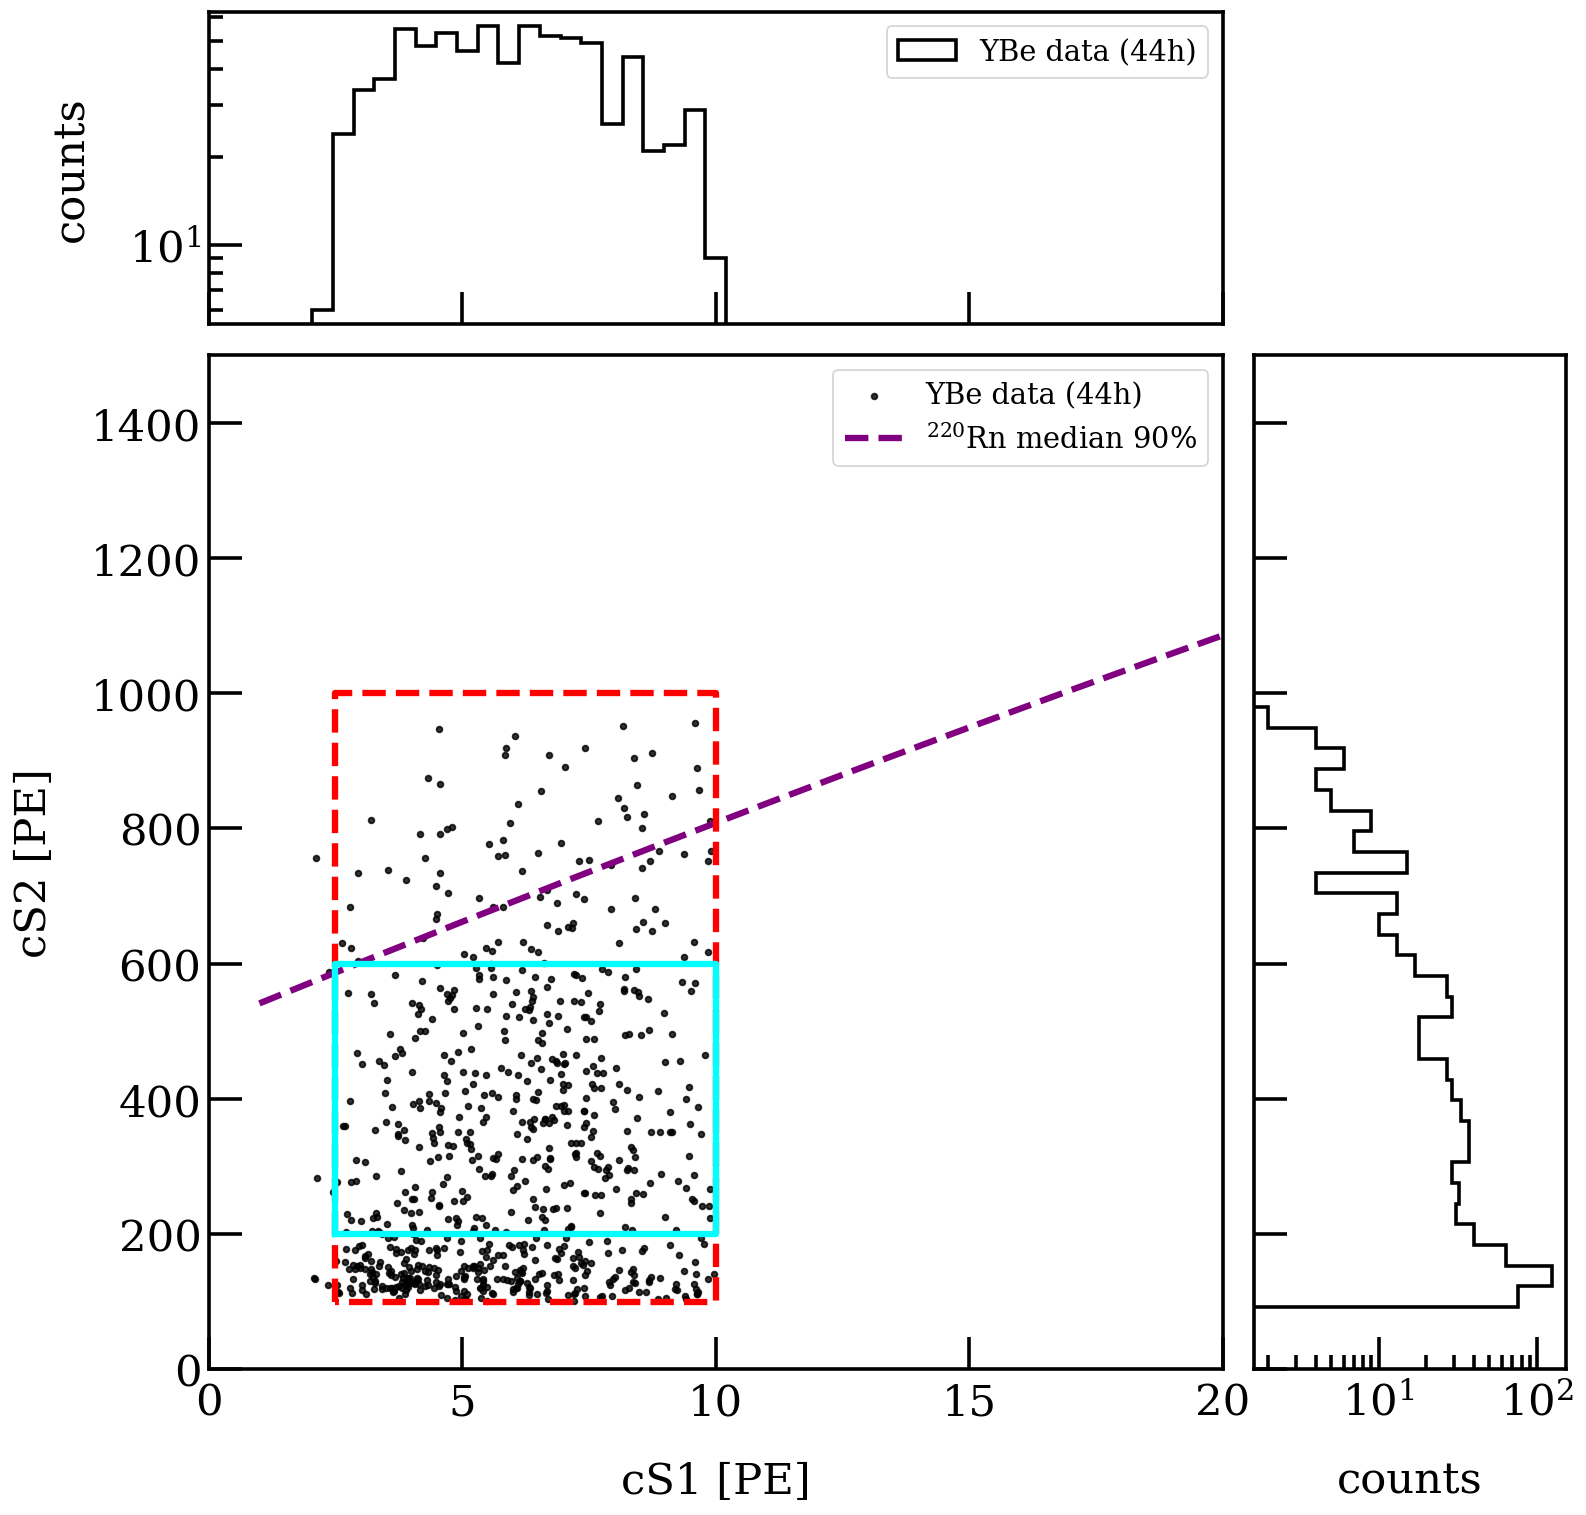

(<Axes:xlabel='cS1 [PE]', ylabel='cS2 [PE]'>,
 <Axes:ylabel='counts'>,
 <Axes:xlabel='counts'>)

In [17]:
plot_cs1cs2_simple(data_clean)

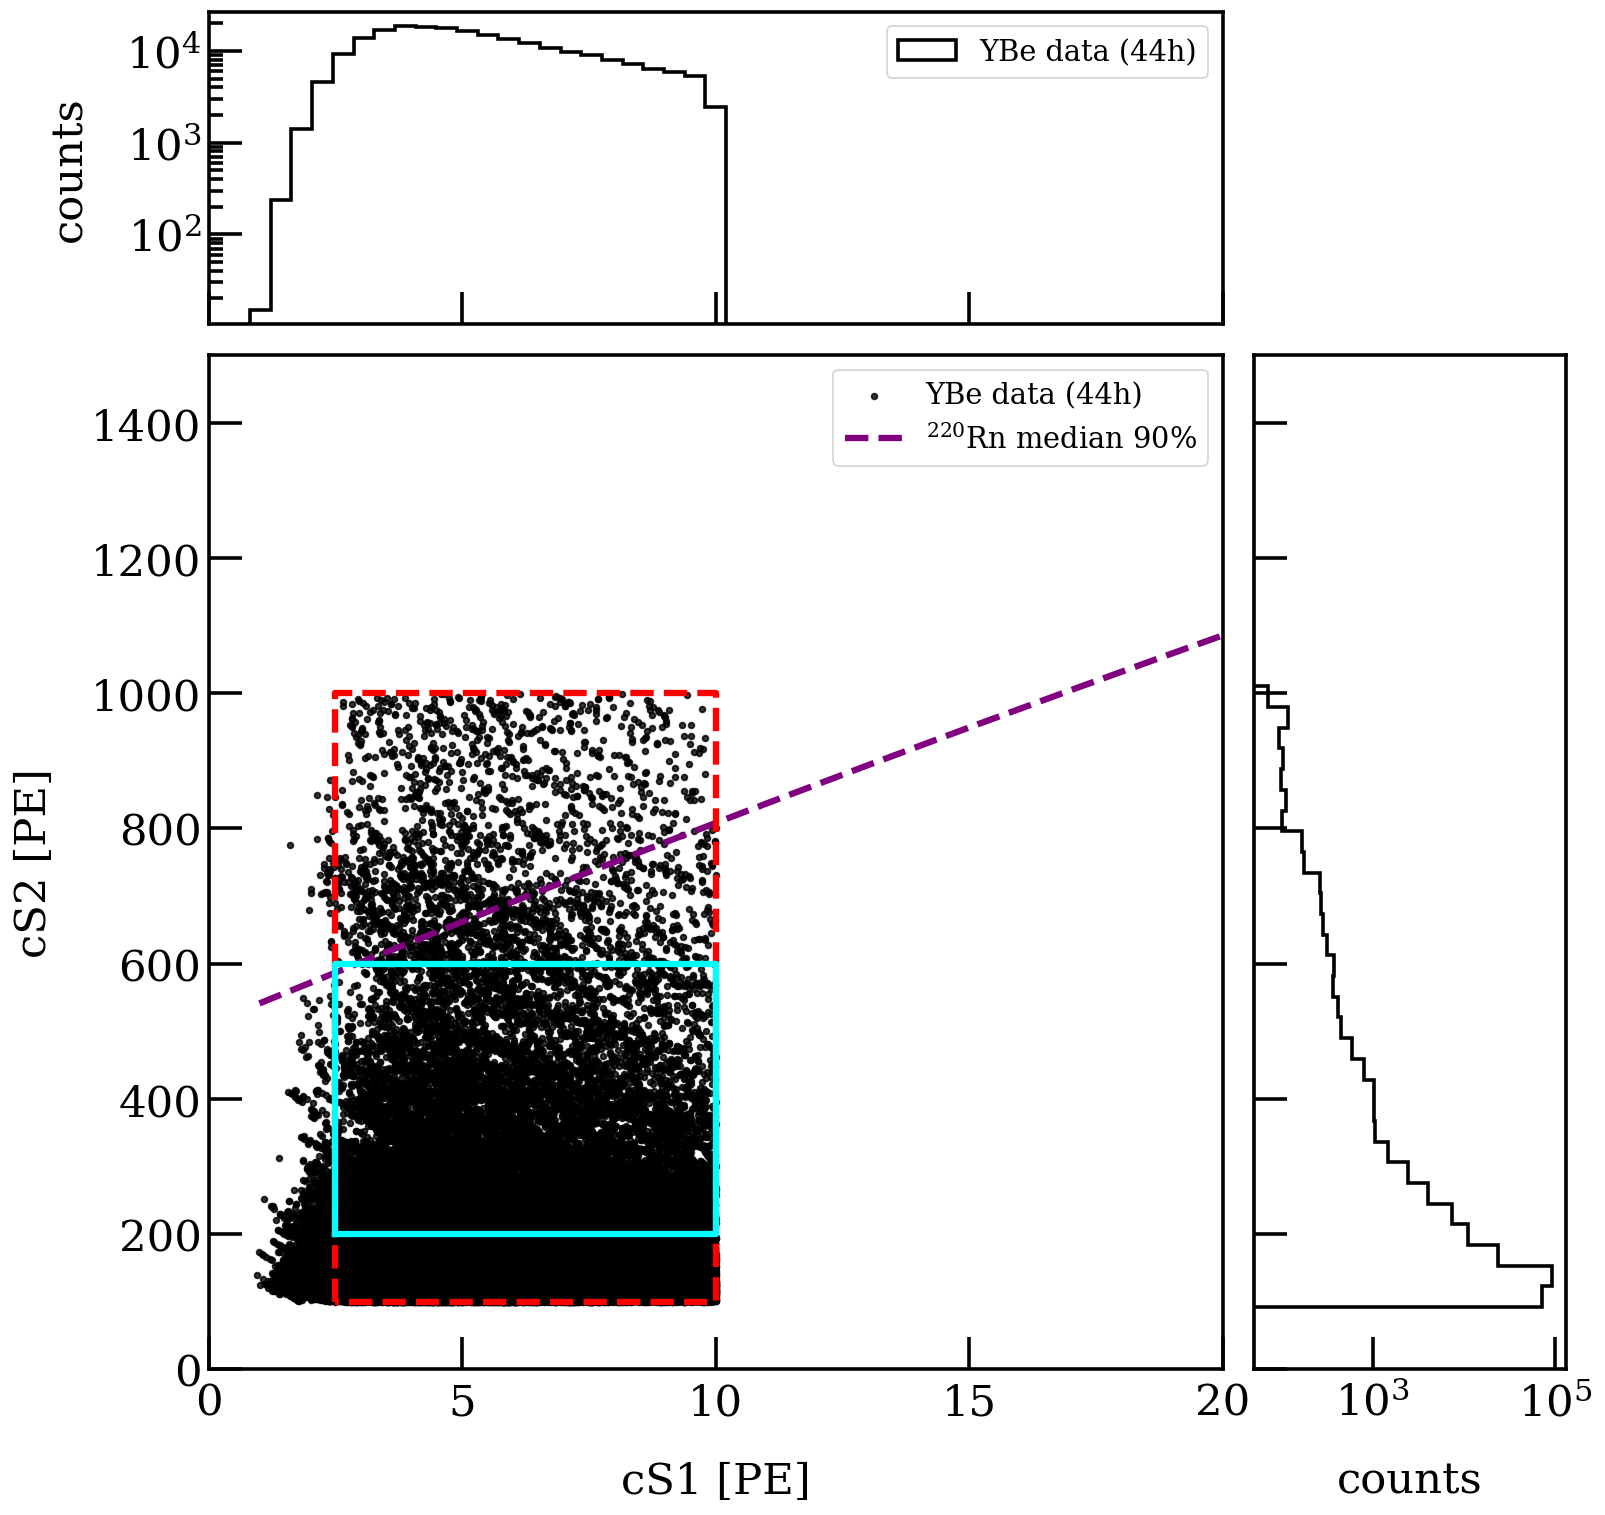

(<Axes:xlabel='cS1 [PE]', ylabel='cS2 [PE]'>,
 <Axes:ylabel='counts'>,
 <Axes:xlabel='counts'>)

In [18]:
plot_cs1cs2_simple(ac_sim_clean)

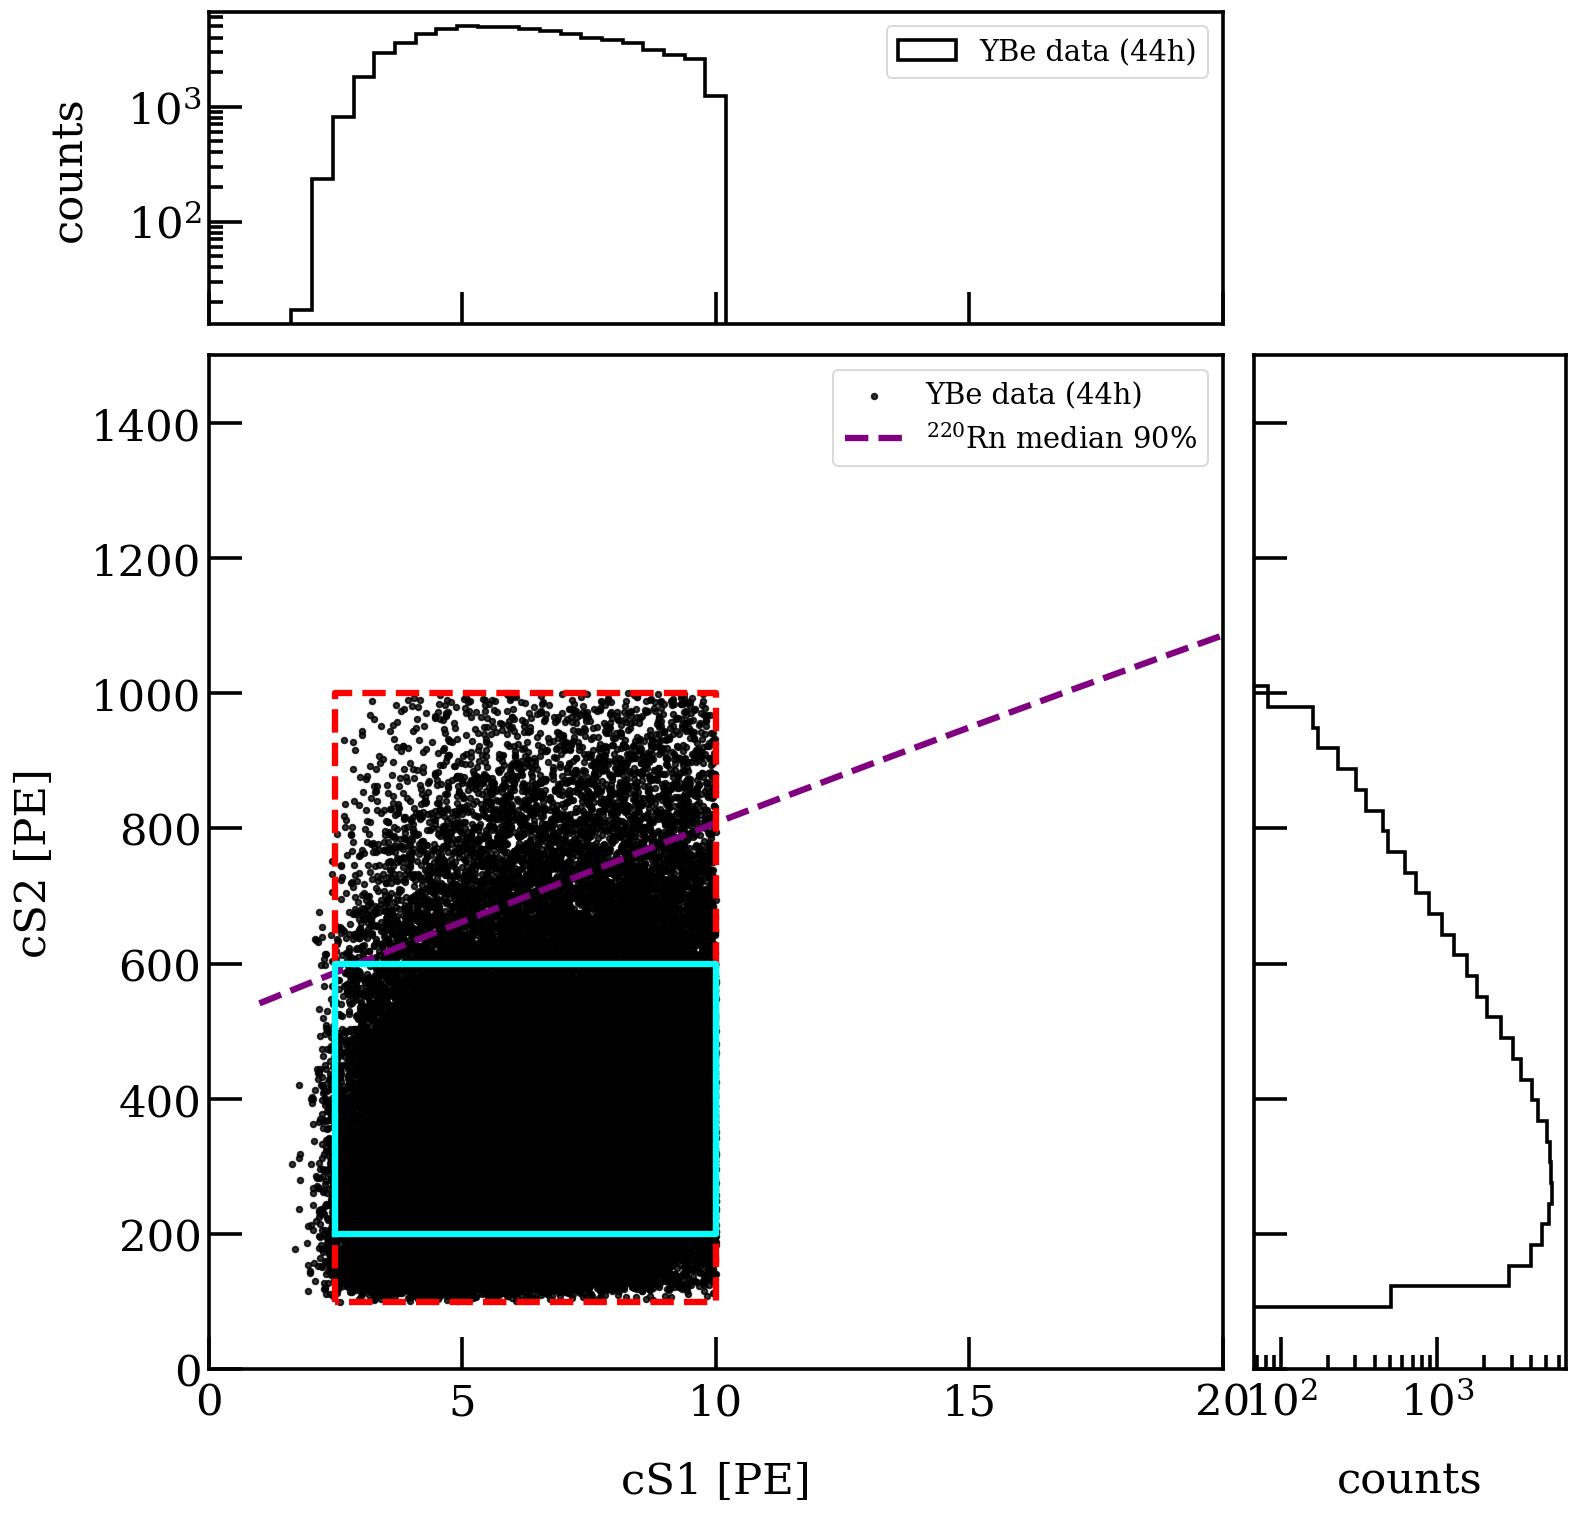

(<Axes:xlabel='cS1 [PE]', ylabel='cS2 [PE]'>,
 <Axes:ylabel='counts'>,
 <Axes:xlabel='counts'>)

In [19]:
plot_cs1cs2_simple(sim_clean)

In [20]:
def get_cut_acc(df,cuts,axis,bins):
    df_cut=df.query(' and '.join(cuts))
    h0=np.histogram(df_cut[axis], bins=bins)[0]
    h1=np.histogram(df[axis], bins=bins)[0]
    acc=np.array(h0)/np.array(h1)
    return acc

In [21]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from sklearn import preprocessing
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
# from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB# try other model 
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
sns.set_style("darkgrid")
from sklearn.inspection import permutation_importance
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)



2023-03-26 22:22:07.081384: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/XENONnT/anaconda/envs/XENONnT_2022.09.1/lib64:/opt/XENONnT/anaconda/envs/XENONnT_2022.09.1/lib:/opt/rh/devtoolset-9/root/usr/lib64:/opt/rh/devtoolset-9/root/usr/lib:/opt/rh/devtoolset-9/root/usr/lib64/dyninst:/opt/rh/devtoolset-9/root/usr/lib/dyninst:/opt/rh/devtoolset-9/root/usr/lib64:/opt/rh/devtoolset-9/root/usr/lib
2023-03-26 22:22:07.081418: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [22]:
ac_sim_clean.loc[:,'ac']=np.ones(len(ac_sim_clean),dtype=int)
sim_clean.loc[:,'ac']=np.zeros(len(sim_clean),dtype=int)

In [23]:
my_bins=(np.linspace(min(data_clean['drift_time']),max(data_clean['drift_time']),50),np.logspace(2,5,50))

In [24]:
def lb(x):
    return 0.0004*x+1e3
def ub(x):
    return 0.0001*x+3e4

In [25]:
def draw_x_percent_line(m2,perc):
    median = m2.percentile(perc, 1)
    w_raw,z_raw=median.bin_centers[:-1],median.histogram[:-1]
    plt.plot(w_raw,z_raw, label=f'{perc}% line')

## Triditional

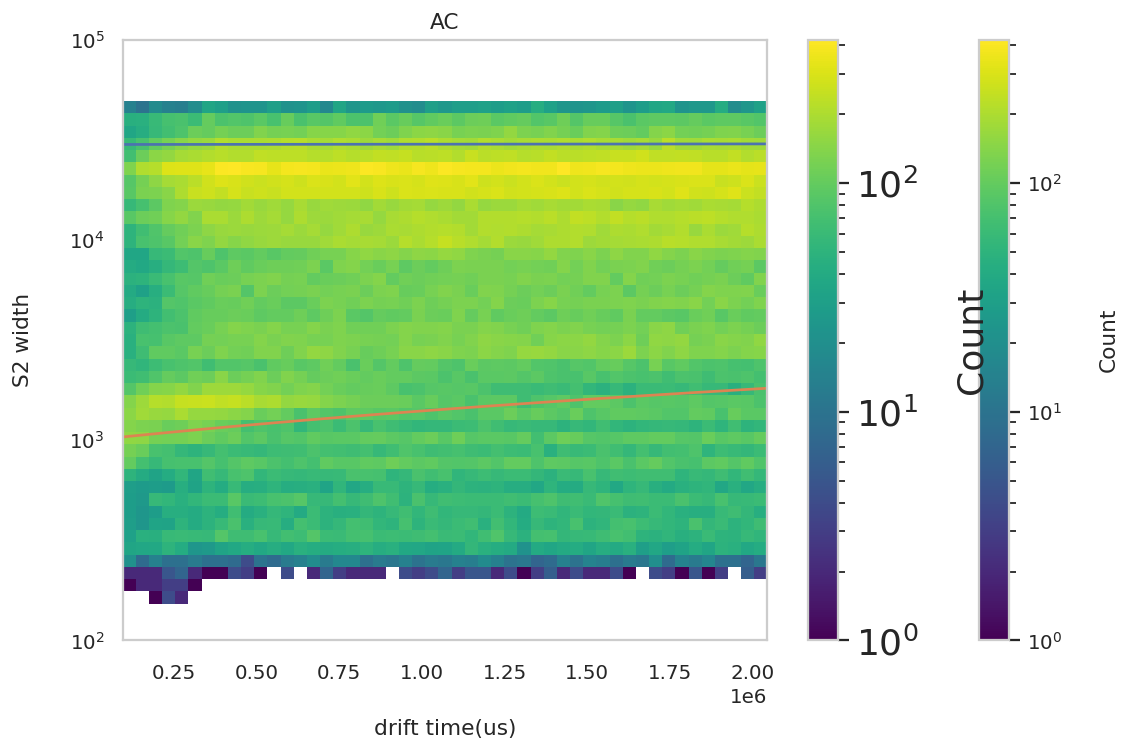

In [25]:
m2 = Histdd(ac_sim_clean['drift_time'],ac_sim_clean['s2_range_50p_area'],bins=my_bins)
m2.plot(cblabel = 'Count', log_scale = True, cmap = 'viridis')
cb = plt.colorbar()
cb.set_label(label='Count',size=20)
cb.ax.tick_params(labelsize = 20)
plt.xlabel('drift time(us)')
plt.ylabel('S2 width')
plt.title("AC")
plt.plot(my_bins[0],ub(my_bins[0]))
plt.plot(my_bins[0],lb(my_bins[0]))
plt.yscale('log')

In [26]:
mask=ac_sim_clean['s2_range_50p_area']<ub(ac_sim_clean['drift_time'])
mask&=ac_sim_clean['s2_range_50p_area']>lb(ac_sim_clean['drift_time'])
len(ac_sim_clean[mask])/len(ac_sim_clean)

0.7558170405201701

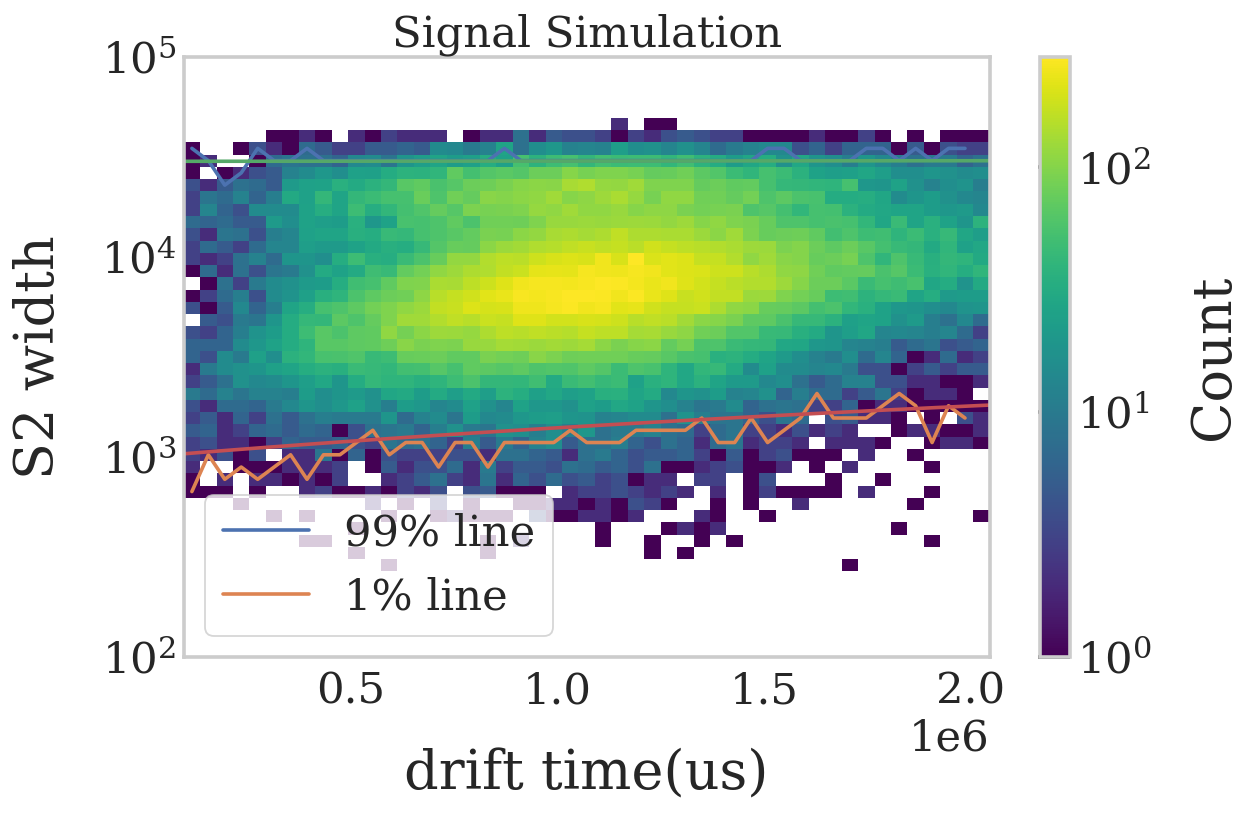

In [31]:
m2 = Histdd(sim_clean['drift_time'],sim_clean['s2_range_50p_area'],bins=my_bins)
m2.plot(cblabel = 'Count', log_scale = True, cmap = 'viridis')
# cb = plt.colorbar()
cb.set_label(label='Count',size=20)
cb.ax.tick_params(labelsize = 20)
plt.title("Signal Simulation")
plt.yscale('log')
plt.xlabel('drift time(us)')
plt.ylabel('S2 width')
draw_x_percent_line(m2,99)
draw_x_percent_line(m2,1)

plt.plot(my_bins[0],ub(my_bins[0]))
plt.plot(my_bins[0],lb(my_bins[0]))
plt.legend()

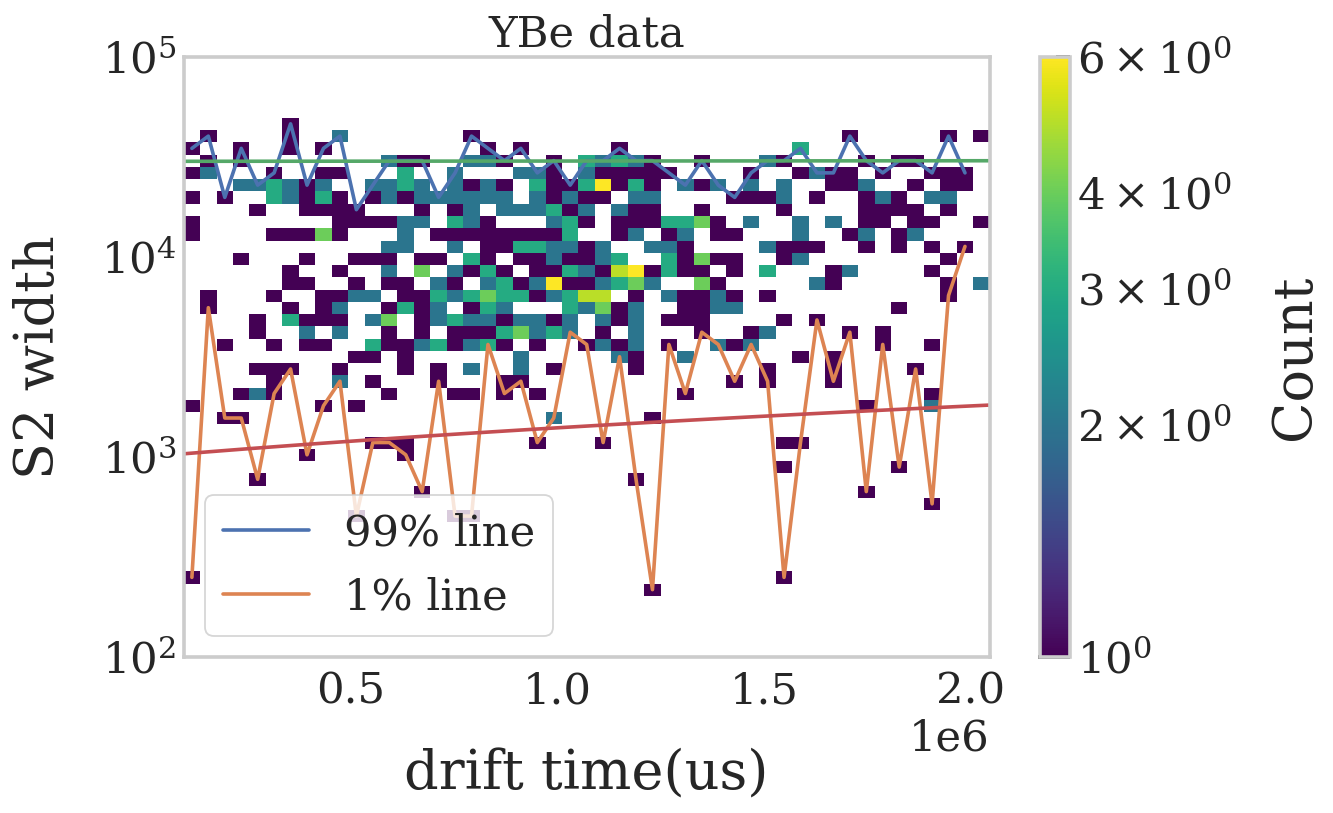

In [32]:
m2 = Histdd(data_clean['drift_time'],data_clean['s2_range_50p_area'],bins=my_bins)
m2.plot(cblabel = 'Count', log_scale = True, cmap = 'viridis')
# cb = plt.colorbar()
cb.set_label(label='Count',size=20)
cb.ax.tick_params(labelsize = 20)
plt.title("YBe data")
plt.xlabel('drift time(us)')
plt.ylabel('S2 width')

draw_x_percent_line(m2,99)
draw_x_percent_line(m2,1)
plt.legend()

plt.plot(my_bins[0],ub(my_bins[0]))
plt.plot(my_bins[0],lb(my_bins[0]))

plt.yscale('log')


plt.show()

## Now ML

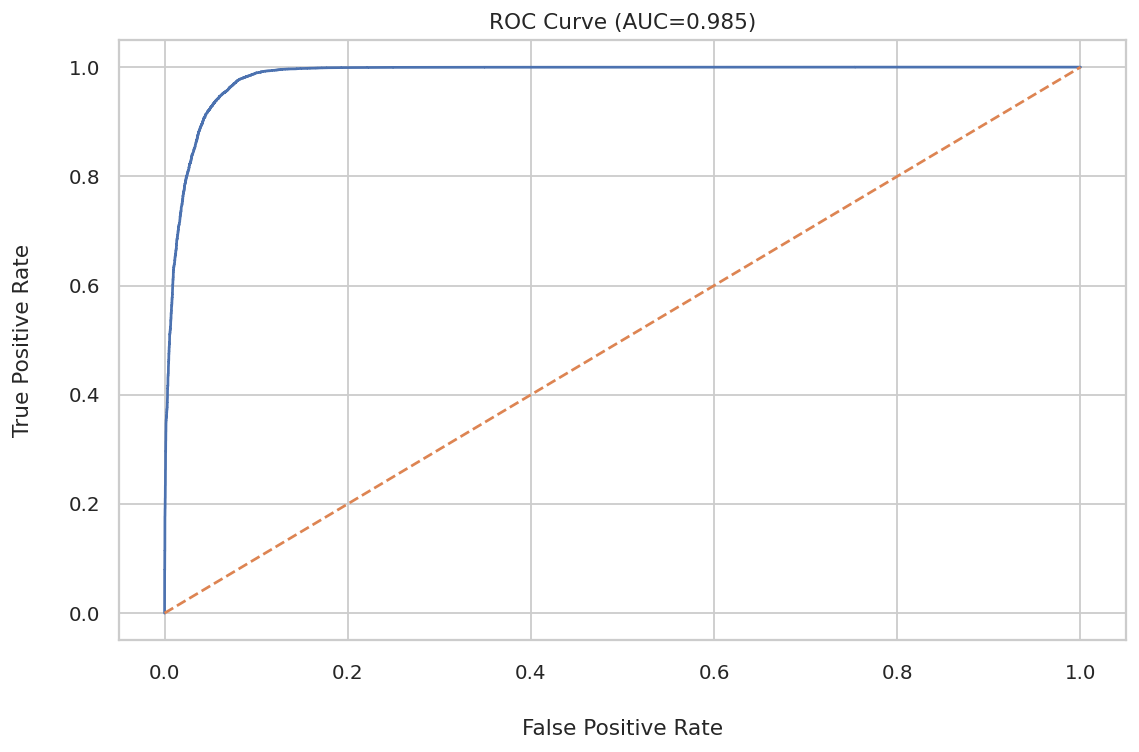

In [26]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


# Choose the common features for both dataframes
features = ['drift_time', 's2_range_50p_area', 's2_area']

# Add a column to indicate the source of each row
ac_sim_clean['ac'] = 1
sim_clean['ac'] = 0

# Merge the two dataframes into one
df = pd.concat([ac_sim_clean[features + ['ac']], sim_clean[features + ['ac']]])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df['ac'], test_size=0.2, random_state=42, stratify=df['ac'])

# Create an XGBoost model
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Train the model
model.fit(X_train, y_train)

# Evaluate the model using ROC curve
y_pred_proba = model.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC={roc_auc:.3f})')
plt.show()


In [27]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Choose two of the three common features for all dataframes
# feature_pairs = [('drift_time', 's2_range_50p_area'), ('s2_range_50p_area', 's2_area'), ('drift_time', 's2_area')]

# # Make predictions on the test set using the XGBoost model
# ac_sim_clean_pred = model.predict_proba(ac_sim_clean[features])[:,1]
# sim_clean_pred = model.predict_proba(sim_clean[features])[:,1]
# data_clean_pred = model.predict_proba(data_clean[features])[:,1]

# # Plot the scatter plots with color bar
# fig, axs = plt.subplots(3, 3, figsize=(30,30), sharey=False)
# for i, (f1, f2) in enumerate(feature_pairs):
#     for j, (df, df_pred, name) in enumerate(zip([ac_sim_clean, sim_clean, data_clean], [ac_sim_clean_pred, sim_clean_pred, data_clean_pred], ['AC', 'YBe Simulation', 'YBe Data'])):
#         size=2
#         if name=='YBe Data':
#             size=40
#         if f2 == 's2_area':
#             axs[i, j].scatter(df[f1], df[f2], c=df_pred, cmap='coolwarm', s=size, alpha=0.9, vmin=0, vmax=1)
#             axs[i, j].set_xlabel(f1)
#             axs[i, j].set_ylabel(f2)
#             axs[i, j].set_title(f'{name}')
#             axs[i, j].set_yscale('log')
#             axs[i, j].set_ylim(90,1100)
#             fig.colorbar(axs[i, j].collections[0], ax=axs[i, j], fraction=0.046, pad=0.04)
#         else:
#             axs[i, j].scatter(df[f1], df[f2], c=df_pred, cmap='coolwarm', s=size, alpha=0.9, vmin=0, vmax=1)
#             axs[i, j].set_xlabel(f1)
#             axs[i, j].set_ylabel(f2)
#             axs[i, j].set_title(f'{name}')
#             fig.colorbar(axs[i, j].collections[0], ax=axs[i, j], fraction=0.046, pad=0.04)
# plt.tight_layout()
# plt.show()


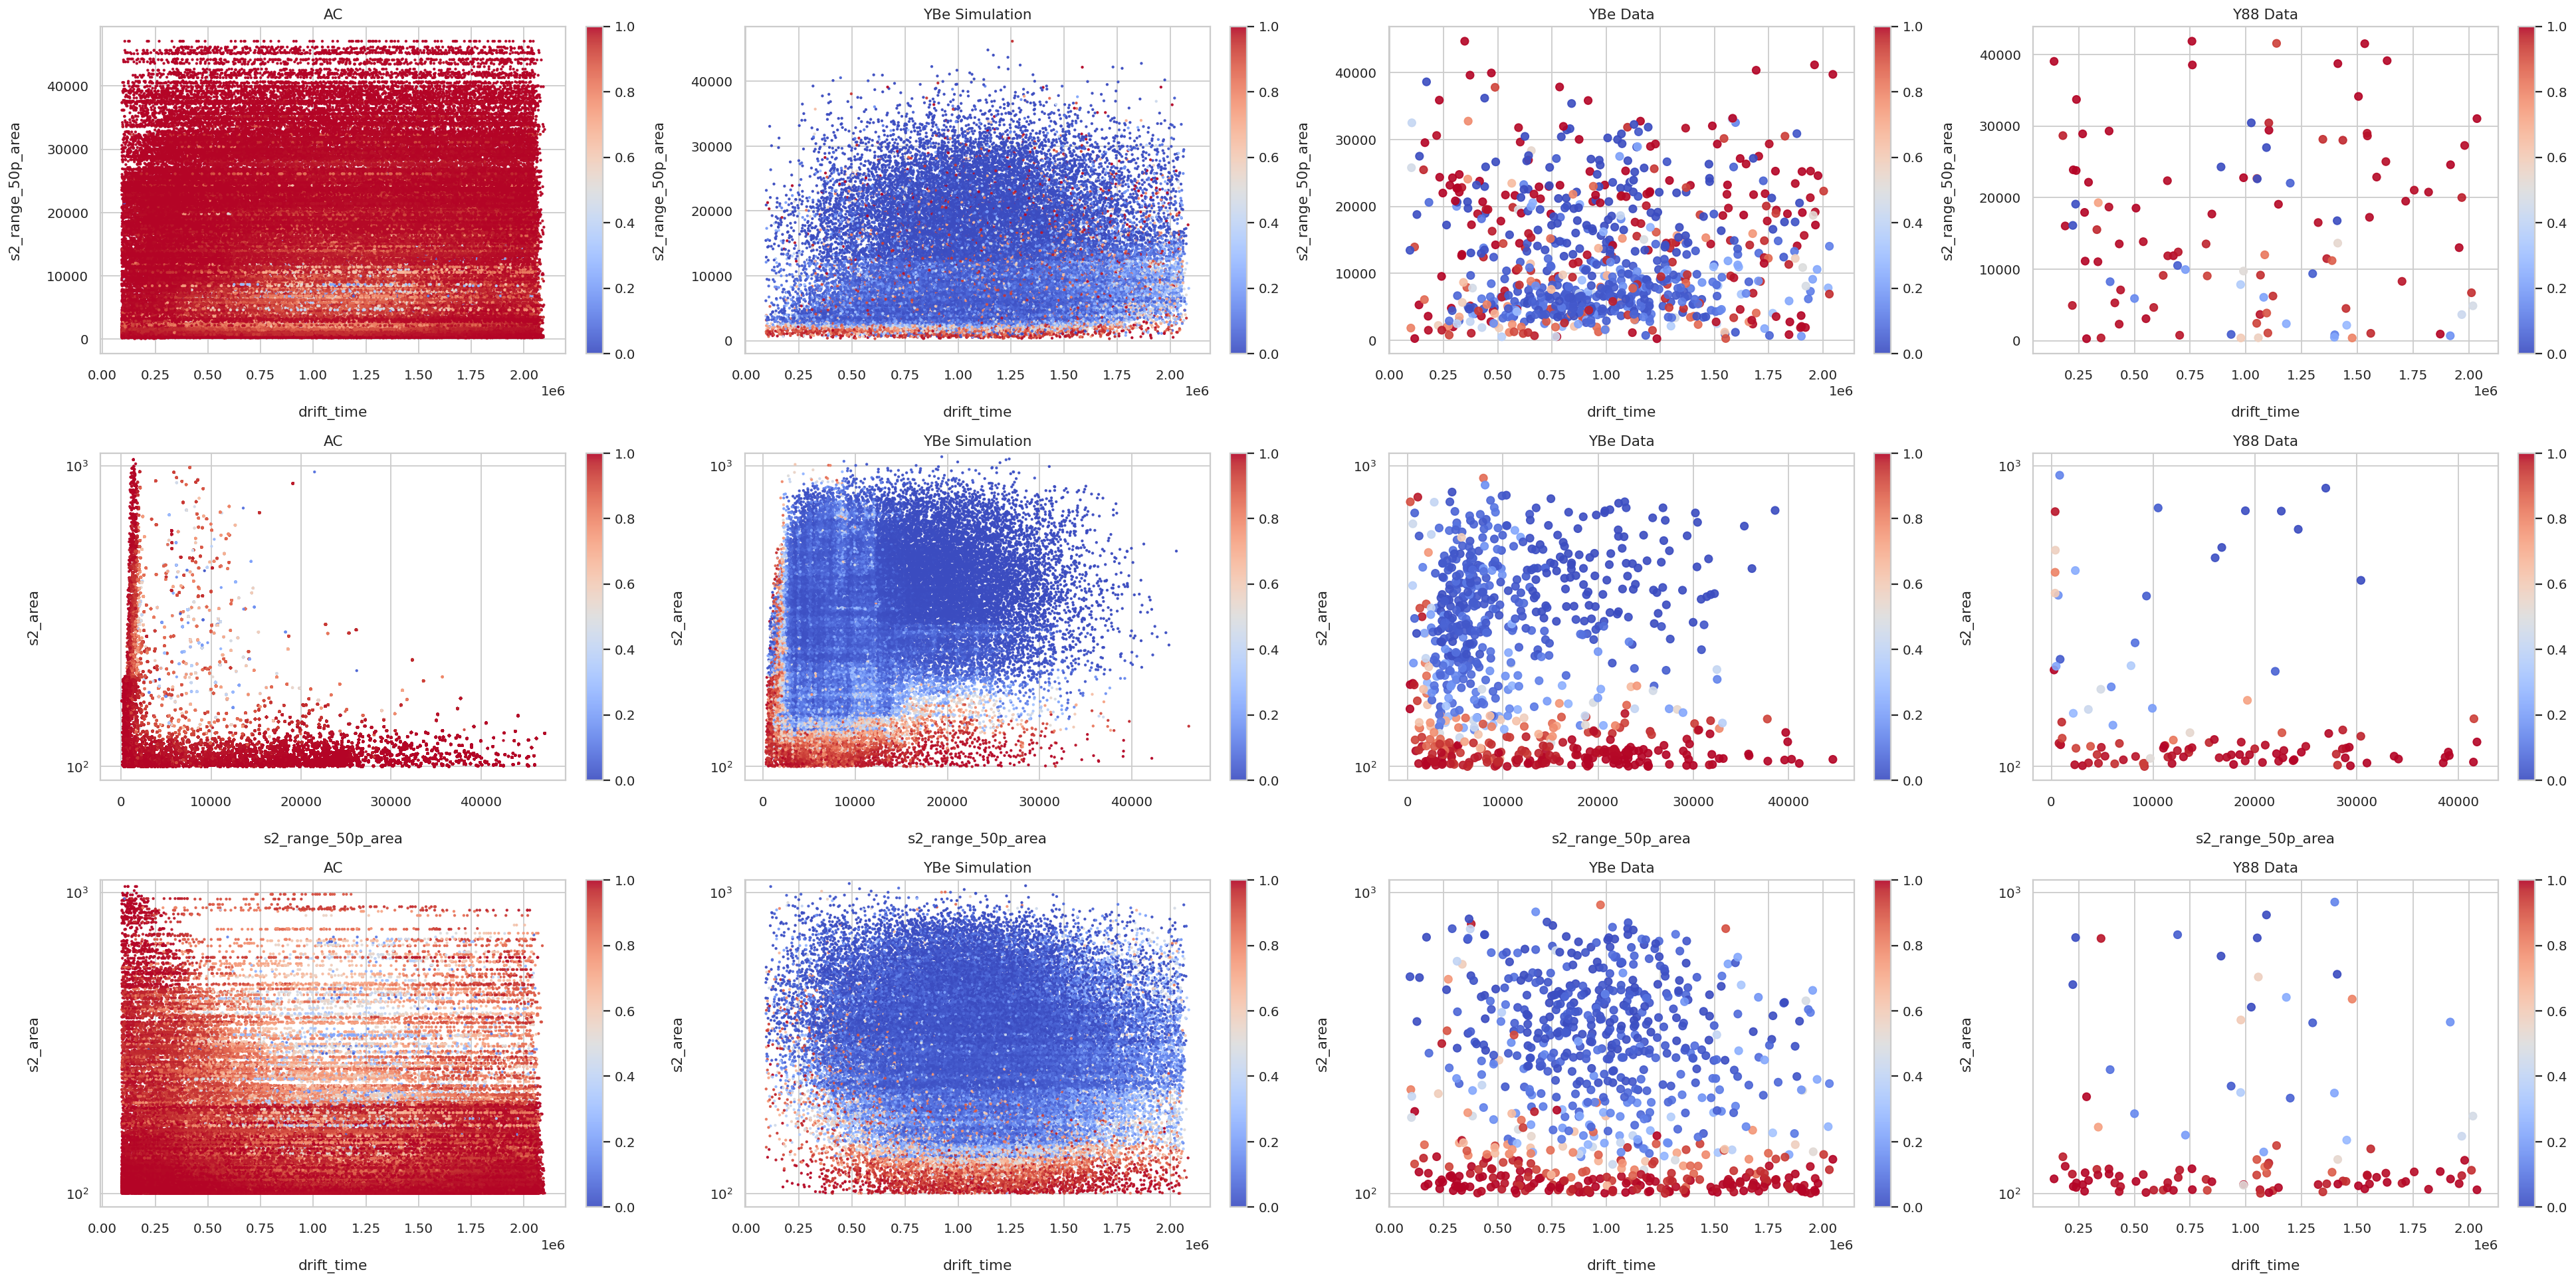

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Choose two of the three common features for all dataframes
feature_pairs = [('drift_time', 's2_range_50p_area'), ('s2_range_50p_area', 's2_area'), ('drift_time', 's2_area')]

# Make predictions on the test set using the XGBoost model
ac_sim_clean_pred = model.predict_proba(ac_sim_clean[features])[:,1]
sim_clean_pred = model.predict_proba(sim_clean[features])[:,1]
data_clean_pred = model.predict_proba(data_clean[features])[:,1]
bkg_clean_pred = model.predict_proba(bkg_clean[features])[:,1]
ac_sim_clean['ac_score'] = ac_sim_clean_pred
sim_clean['ac_score'] = sim_clean_pred
data_clean['ac_score'] = data_clean_pred
bkg_clean['ac_score'] = bkg_clean_pred


# Plot the scatter plots with color bar
fig, axs = plt.subplots(3, 4, figsize=(30,15), sharey=False)
for i, (f1, f2) in enumerate(feature_pairs):
    for j, (df, df_pred, name) in enumerate(zip([ac_sim_clean, sim_clean, data_clean, bkg_clean], [ac_sim_clean_pred, sim_clean_pred, data_clean_pred, bkg_clean_pred], ['AC', 'YBe Simulation', 'YBe Data', 'Y88 Data'])):
        size=2
        if name=='YBe Data' or name=='Y88 Data':
            size=40
        if f2 == 's2_area':
            axs[i, j].scatter(df[f1], df[f2], c=df_pred, cmap='coolwarm', s=size, alpha=0.9, vmin=0, vmax=1)
            axs[i, j].set_xlabel(f1)
            axs[i, j].set_ylabel(f2)
            axs[i, j].set_title(f'{name}')
            axs[i, j].set_yscale('log')
            axs[i, j].set_ylim(90,1100)
            fig.colorbar(axs[i, j].collections[0], ax=axs[i, j], fraction=0.046, pad=0.04)
        else:
            axs[i, j].scatter(df[f1], df[f2], c=df_pred, cmap='coolwarm', s=size, alpha=0.9, vmin=0, vmax=1)
            axs[i, j].set_xlabel(f1)
            axs[i, j].set_ylabel(f2)
            axs[i, j].set_title(f'{name}')
            fig.colorbar(axs[i, j].collections[0], ax=axs[i, j], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


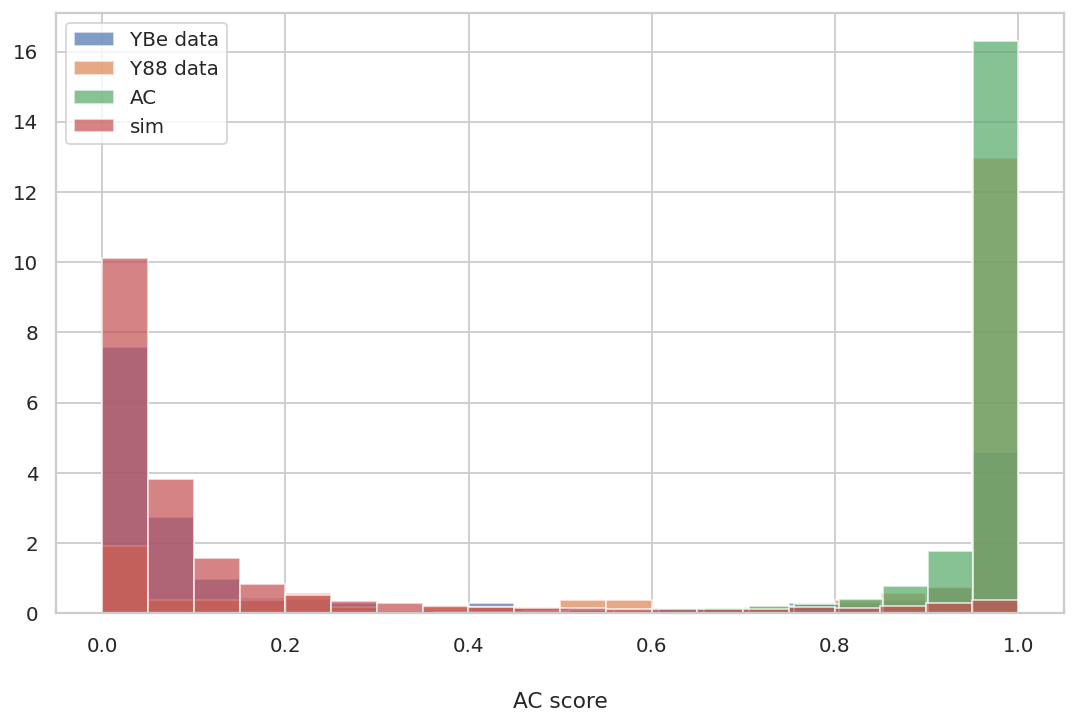

In [29]:
plt.hist(data_clean_pred,bins=20,density=True,label='YBe data',alpha=0.7)
plt.hist(bkg_clean_pred,bins=20,density=True,label='Y88 data',alpha=0.7)
plt.hist(ac_sim_clean_pred,bins=20,density=True,label='AC',alpha=0.7)
plt.hist(sim_clean_pred,bins=20,density=True,label='sim',alpha=0.7)
plt.xlabel('AC score')
plt.legend()
plt.show()

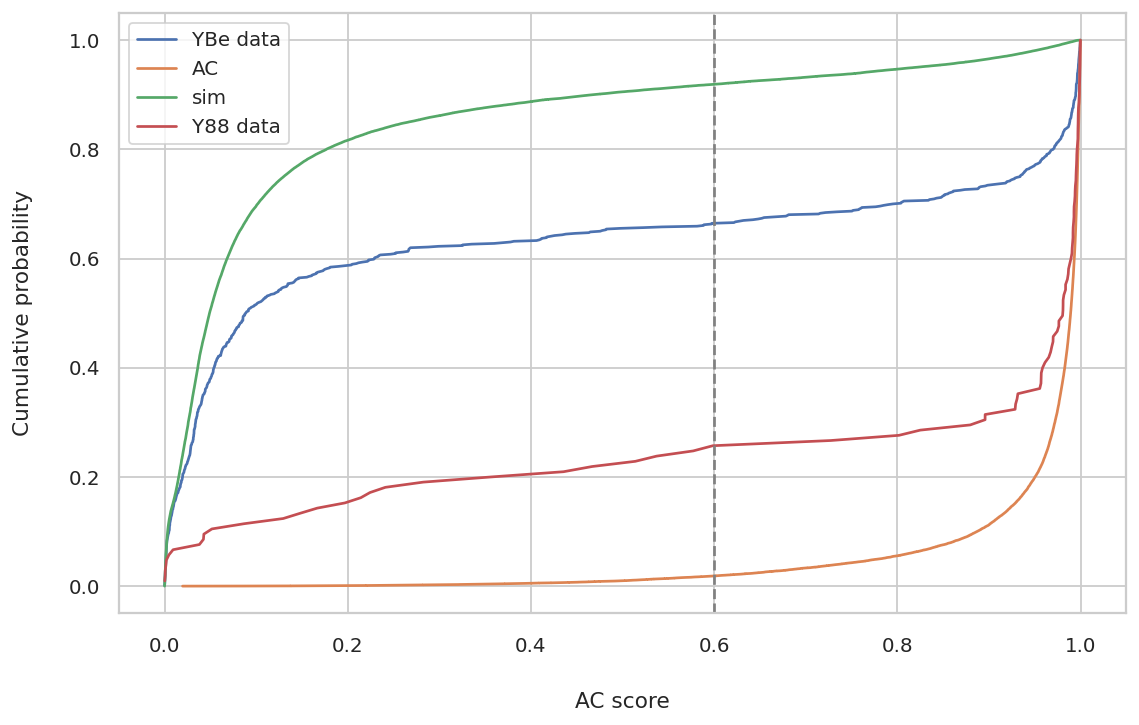

In [30]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Compute the ECDF of the AC scores for each dataframe
ecdf_data_clean = sm.distributions.ECDF(data_clean_pred)
ecdf_ac_sim_clean = sm.distributions.ECDF(ac_sim_clean_pred)
ecdf_sim_clean = sm.distributions.ECDF(sim_clean_pred)
ecdf_bkg_clean = sm.distributions.ECDF(bkg_clean_pred)

# Plot the CDFs
plt.plot(ecdf_data_clean.x, ecdf_data_clean.y, label='YBe data')
plt.plot(ecdf_ac_sim_clean.x, ecdf_ac_sim_clean.y, label='AC')
plt.plot(ecdf_sim_clean.x, ecdf_sim_clean.y, label='sim')
plt.plot(ecdf_bkg_clean.x, ecdf_bkg_clean.y, label='Y88 data')
plt.axvline(0.6,color='grey',linestyle='--')
plt.xlabel('AC score')
plt.ylabel('Cumulative probability')
plt.legend()
plt.show()


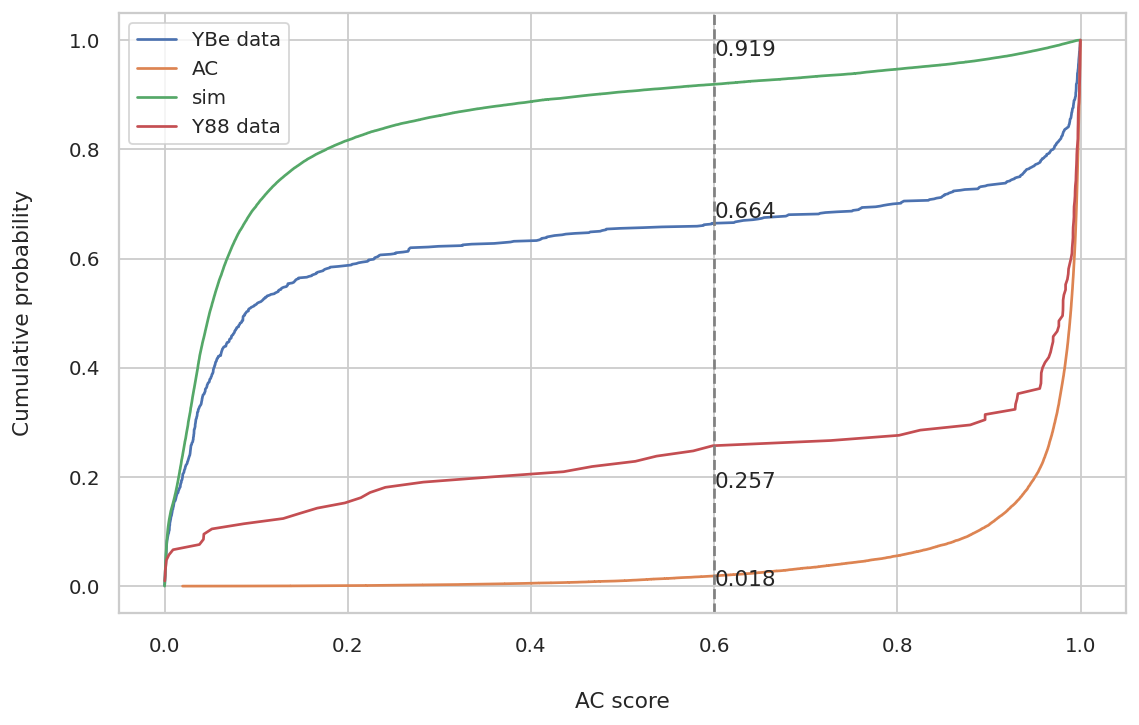

In [31]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Compute the ECDF of the AC scores for each dataframe
ecdf_data_clean = sm.distributions.ECDF(data_clean_pred)
ecdf_ac_sim_clean = sm.distributions.ECDF(ac_sim_clean_pred)
ecdf_sim_clean = sm.distributions.ECDF(sim_clean_pred)
ecdf_bkg_clean = sm.distributions.ECDF(bkg_clean_pred)

# Plot the CDFs
plt.plot(ecdf_data_clean.x, ecdf_data_clean.y, label='YBe data')
plt.plot(ecdf_ac_sim_clean.x, ecdf_ac_sim_clean.y, label='AC')
plt.plot(ecdf_sim_clean.x, ecdf_sim_clean.y, label='sim')
plt.plot(ecdf_bkg_clean.x, ecdf_bkg_clean.y, label='Y88 data')
plt.axvline(0.6, color='grey', linestyle='--')
plt.xlabel('AC score')
plt.ylabel('Cumulative probability')
plt.legend()

# Calculate intersection values
ac_threshold = ecdf_ac_sim_clean.y[np.argmin(np.abs(ecdf_ac_sim_clean.x - 0.6))]
data_threshold = ecdf_data_clean.y[np.argmin(np.abs(ecdf_data_clean.x - 0.6))]
sim_threshold = ecdf_sim_clean.y[np.argmin(np.abs(ecdf_sim_clean.x - 0.6))]
bkg_threshold = ecdf_bkg_clean.y[np.argmin(np.abs(ecdf_bkg_clean.x - 0.6))]

# Show intersection values
plt.text(0.6, ecdf_ac_sim_clean(ac_threshold), f'{ac_threshold:.3f}', fontsize=12)
plt.text(0.6, ecdf_data_clean(data_threshold), f'{data_threshold:.3f}', fontsize=12)
plt.text(0.6, ecdf_sim_clean(sim_threshold), f'{sim_threshold:.3f}', fontsize=12)
plt.text(0.6, ecdf_bkg_clean(bkg_threshold), f'{bkg_threshold:.3f}', fontsize=12)

plt.show()


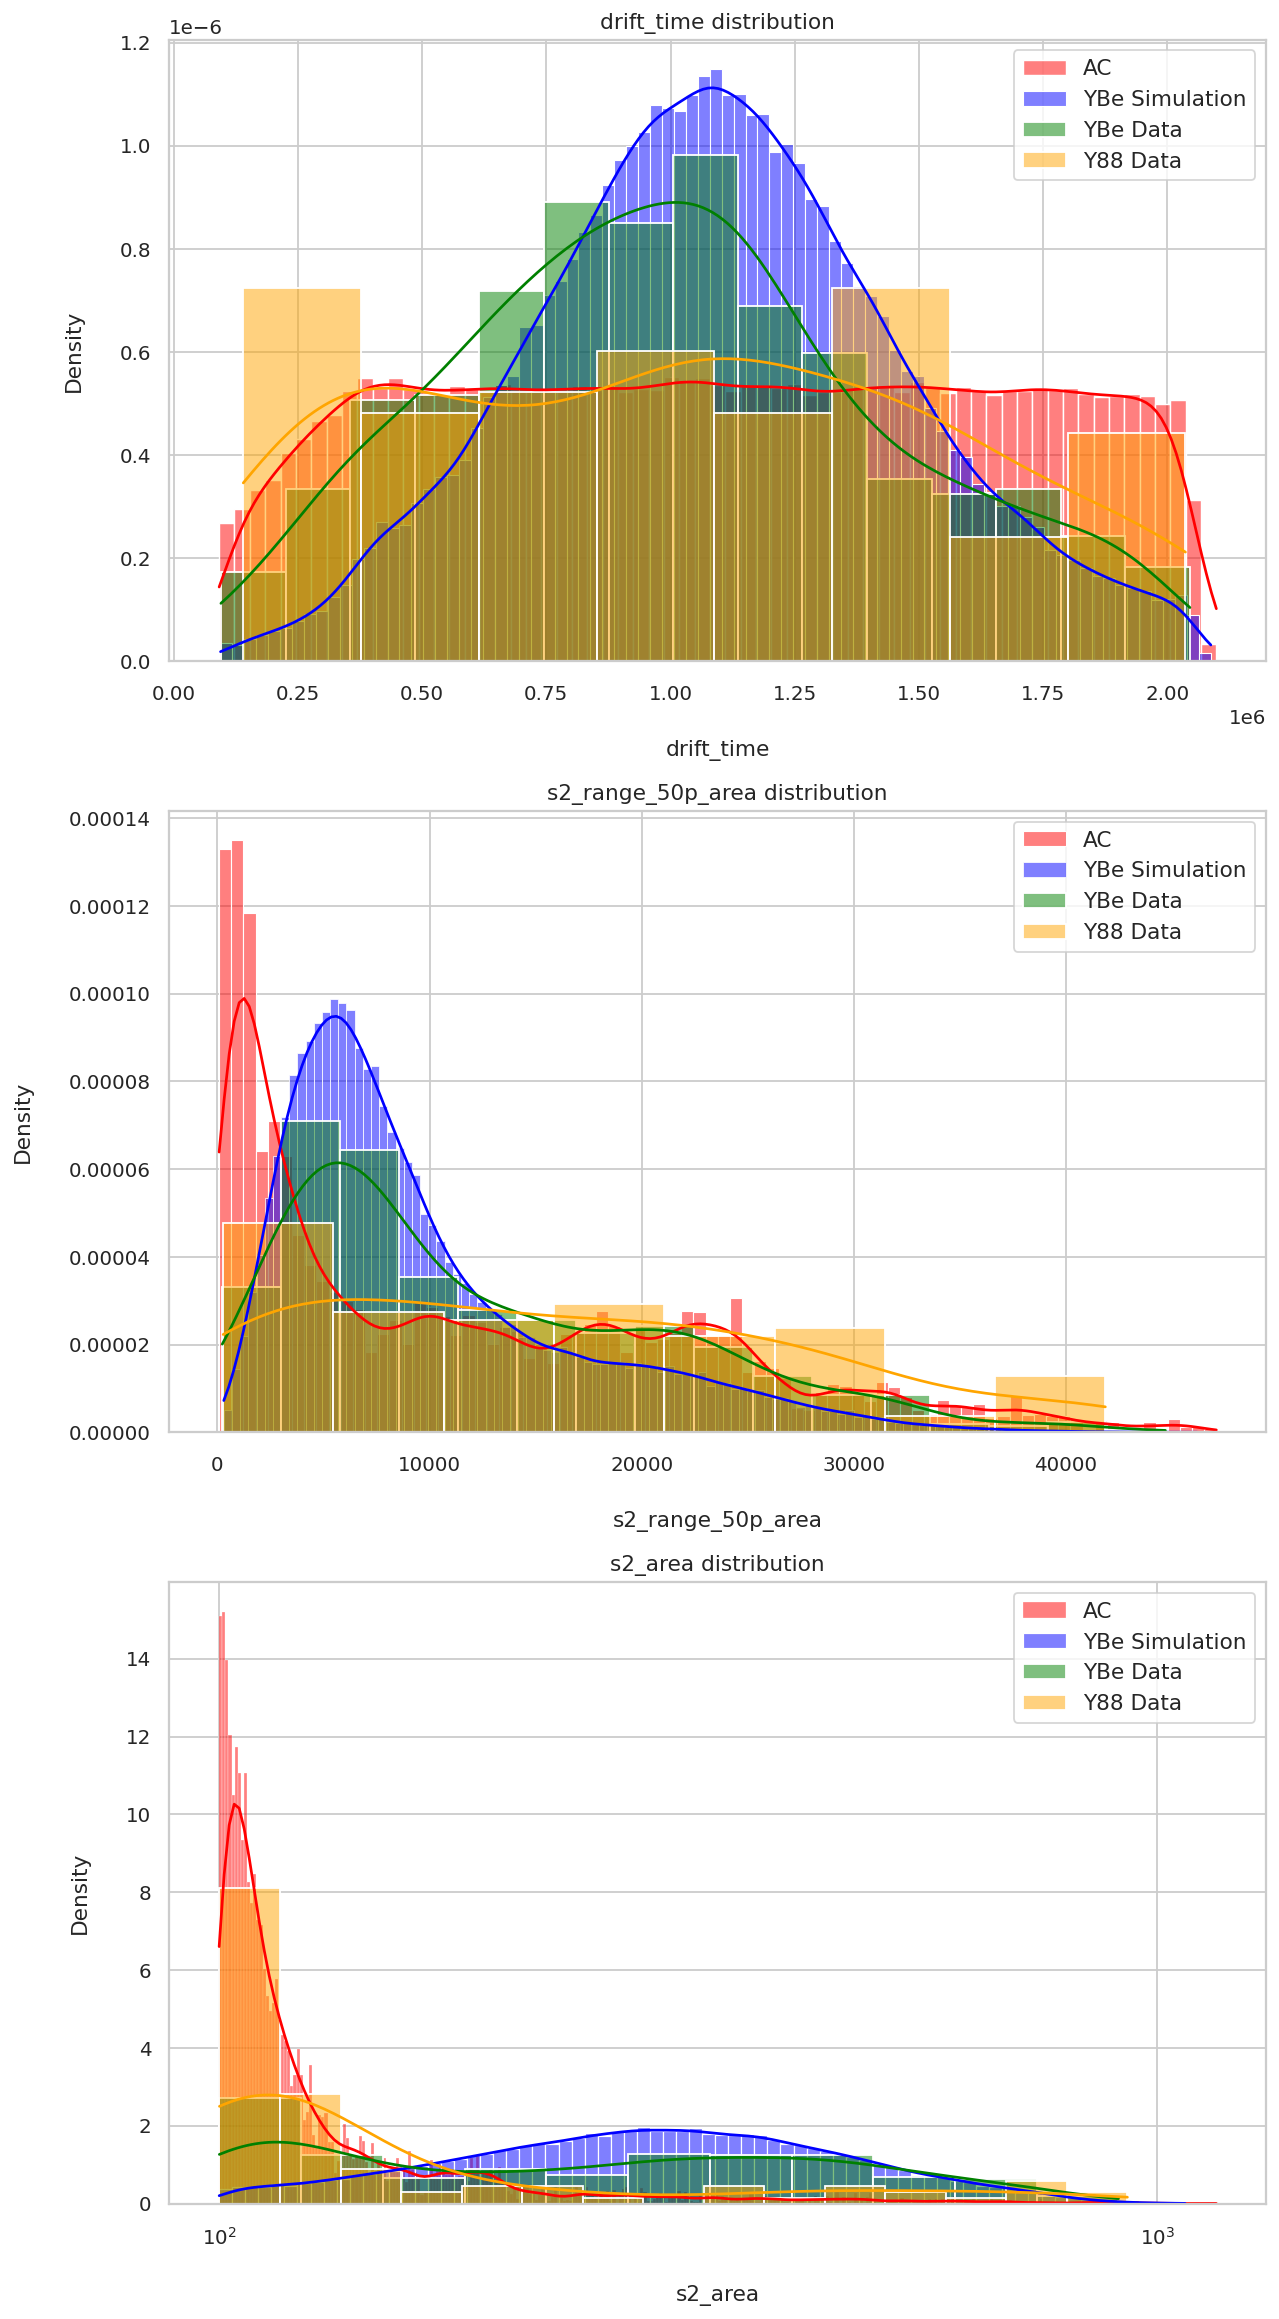

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Choose the common features for all dataframes
features = ['drift_time', 's2_range_50p_area', 's2_area']
names=['AC','YBe Simulation','YBe Data']

# Create a grid of subplots with three rows
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 18))

# Loop through the features and plot each one on its corresponding subplot
for i, feature in enumerate(features):
    log_scale = False
    if feature == 's2_area':
        log_scale = True
    sns.histplot(ac_sim_clean[feature], kde=True, label='AC', ax=axs[i], color='red', stat='density', log_scale=log_scale)
    sns.histplot(sim_clean[feature], kde=True, label='YBe Simulation', ax=axs[i], color='blue', stat='density', log_scale=log_scale)
    sns.histplot(data_clean[feature], kde=True, label='YBe Data', ax=axs[i], color='green', stat='density', log_scale=log_scale)
    sns.histplot(bkg_clean[feature], kde=True, label='Y88 Data', ax=axs[i], color='orange', stat='density', log_scale=log_scale)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Density')
    axs[i].set_title(f'{feature} distribution')
    axs[i].legend(fontsize=12)

plt.tight_layout()
plt.show()


In [33]:
import numpy as np

# Define the range of ac_score thresholds
thresholds = np.linspace(0, 1, 101)

# Initialize empty lists to store the ratios surviving the cut
sim_clean_ratios = []
ac_sim_clean_ratios = []

# Calculate the ratio surviving the cut for each threshold
for threshold in thresholds:
    # Calculate the number of data points surviving the cut for sim_clean and ac_sim_clean
    sim_clean_survived = len(sim_clean[sim_clean['ac_score'] <= threshold])
    ac_sim_clean_survived = len(ac_sim_clean[ac_sim_clean['ac_score'] <= threshold])
    
    # Calculate the ratio surviving the cut
    sim_clean_ratio = sim_clean_survived / len(sim_clean)
    ac_sim_clean_ratio = ac_sim_clean_survived / len(ac_sim_clean)
    
    # Append the ratios to the corresponding lists
    sim_clean_ratios.append(sim_clean_ratio)
    ac_sim_clean_ratios.append(ac_sim_clean_ratio)


In [34]:
def other_s2_cuts(df):
    mask=df.cut_s2_single_scatter
    mask&=df.cut_s2_pattern
    mask&=df.cut_s2_width_wire_modeled_wimps
    return df[mask]

In [35]:
def ac_cut(df):
    return df[df['ac_score'] < 0.6]

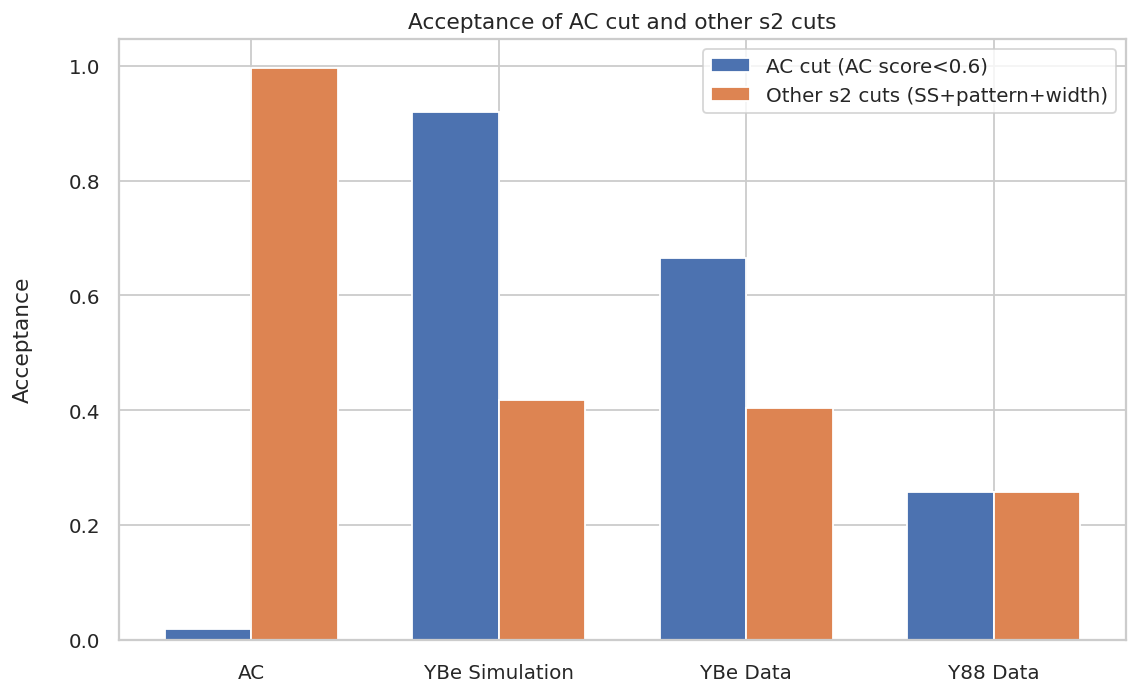

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the acceptance functions
def ac_cut(df):
    return df[df['ac_score'] < 0.6]

def other_s2_cuts(df):
    mask=df.cut_s2_single_scatter
    mask&=df.cut_s2_pattern
    mask&=df.cut_s2_width_wire_modeled_wimps
    return df[mask]

# Calculate the acceptance for each dataframe and cut
ac_acceptance = []
other_s2_acceptance = []

for df in [ac_sim_clean, sim_clean, data_clean, bkg_clean]:
    ac_acceptance.append(len(ac_cut(df)) / len(df))
    other_s2_acceptance.append(len(other_s2_cuts(df)) / len(df))

# Create the bar plot
x = np.arange(4)
width = 0.35
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, ac_acceptance, width, label='AC cut (AC score<0.6)')
ax.bar(x + width/2, other_s2_acceptance, width, label='Other s2 cuts (SS+pattern+width)')
ax.set_xticks(x)
ax.set_xticklabels(['AC','YBe Simulation','YBe Data','Y88 Data'])
ax.set_ylabel('Acceptance')
ax.set_title('Acceptance of AC cut and other s2 cuts')
ax.legend()
plt.show()


In [37]:
data_clean.cut_s2_single_scatter.unique()

array([False,  True])

In [38]:
bkg_clean.cut_s2_single_scatter.unique()

array([ True, False])

In [39]:
ac_sim_clean.cut_s2_single_scatter.unique()

array([ True, False])

In [40]:
data_clean.cut_bdt_ac.unique()

array([False,  True])

In [41]:
#how many data left?
len(ac_cut(data_clean))

505

In [50]:
np.linspace(100,1000,46)

array([ 100.,  120.,  140.,  160.,  180.,  200.,  220.,  240.,  260.,
        280.,  300.,  320.,  340.,  360.,  380.,  400.,  420.,  440.,
        460.,  480.,  500.,  520.,  540.,  560.,  580.,  600.,  620.,
        640.,  660.,  680.,  700.,  720.,  740.,  760.,  780.,  800.,
        820.,  840.,  860.,  880.,  900.,  920.,  940.,  960.,  980.,
       1000.])

In [59]:
#s2 acc
def acc_cut(df):
    acc=[]
    size=25
    bins=np.arange(100,1000,size)
    for i in bins[:-1]:
        df_temp=df[(df.cs2>i)&(df.cs2<=i+size)]
        if(len(df_temp)==0):
            acc.append(np.nan)
        else:
            acc.append(len(ac_cut(df_temp))/len(df_temp))
    plt.plot(bins[:-1]+size/2,acc)
    return acc

[0.020618556701030927,
 0.1592920353982301,
 0.5855855855855856,
 0.8609106052193226,
 0.9239373601789709,
 0.9551859551859552,
 0.972686230248307,
 0.9762672811059908,
 0.982837528604119,
 0.9893842887473461,
 0.989938080495356,
 0.9902669632925473,
 0.991556091676719,
 0.9964949176305643,
 0.9958364875094625,
 0.99263431542461,
 0.9939363314805457,
 0.9922894424673784,
 0.997275204359673,
 0.9978005865102639,
 0.9965899403239556,
 0.9978925184404637,
 0.9988726042841037,
 0.997179125528914,
 0.9923312883435583,
 0.9943502824858758,
 0.9956521739130435,
 0.9973890339425587,
 0.9972144846796658,
 0.9865319865319865,
 0.9925650557620818,
 0.985781990521327,
 0.9888268156424581,
 0.9924812030075187,
 0.9779411764705882]

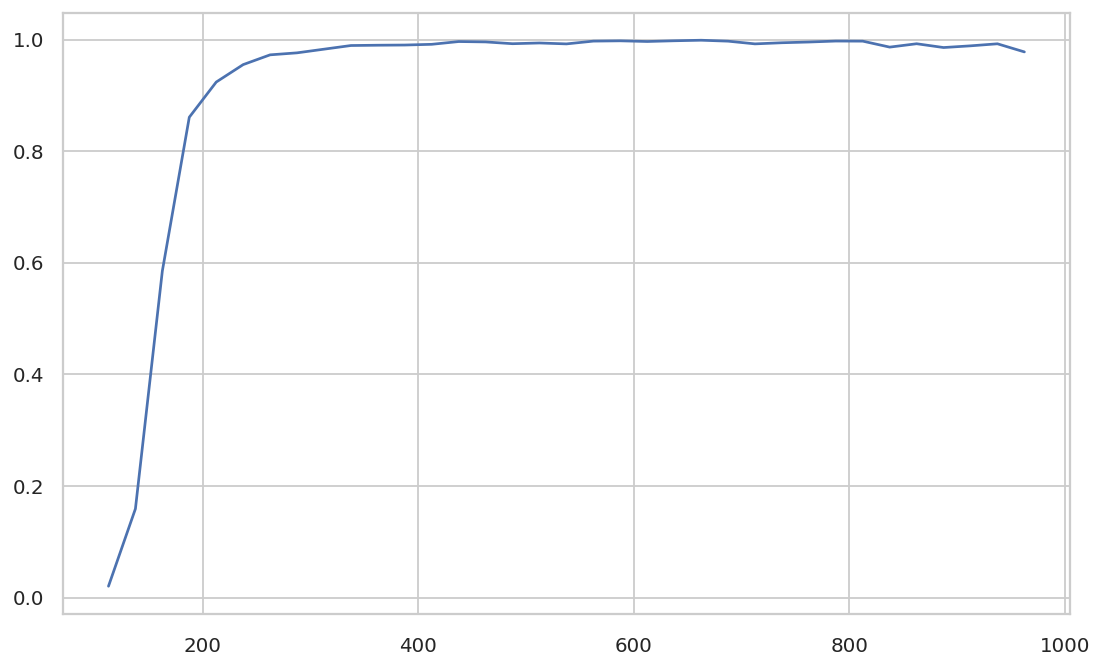

In [60]:
acc_cut(sim_clean)